# Análise De Queimadas EUA + Aplicação e instrução para prevenção de tragédias

- Vinicius Silva - RM553240
- Victor Didoff - RM552965
- Matheu Zottis - RM94119

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [13]:
# Carregar os dados
file_path = "wildfires.csv"
df = pd.read_csv(file_path, low_memory=False)

np.random.seed(14)

# Seleciona 500 mil quemadas aleatórias com base na semente 14 (0+5+9)
amostra = df.sample(n=500_000, replace=False, random_state=14)

### Vamos analizar as Causas de incendios\queimadas no geral.

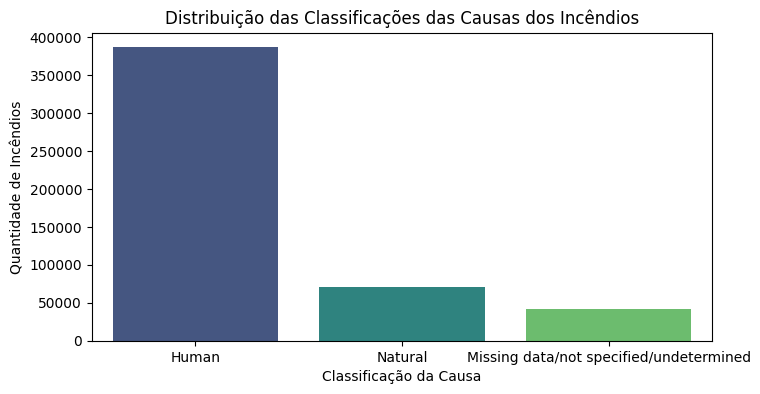

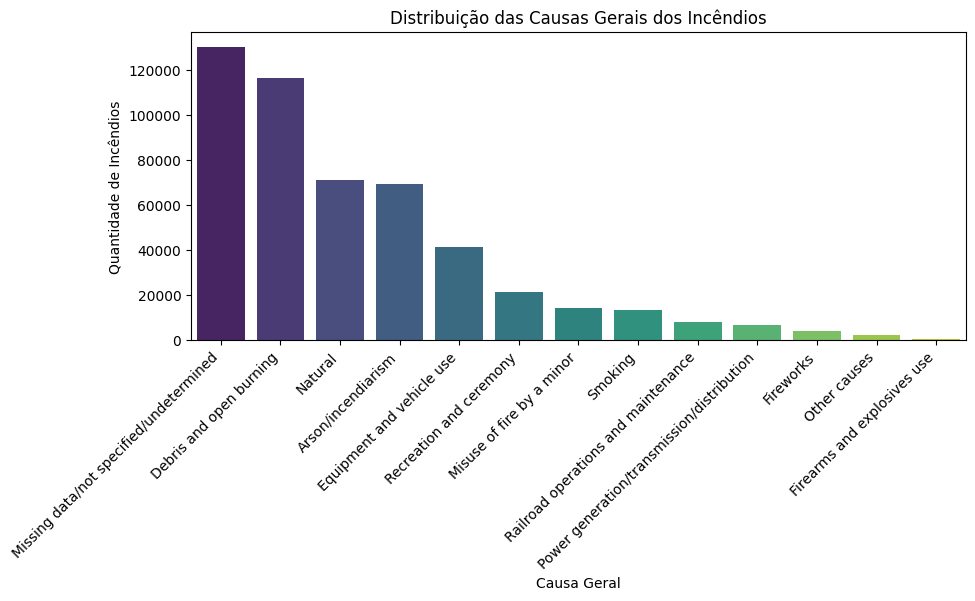

In [34]:
# Gráfico de classificação das causas dos incêndios
classificacao_causas = amostra['NWCG_CAUSE_CLASSIFICATION'].value_counts()
fig_classificacao, ax_classificacao = plt.subplots(figsize=(8, 4))
sns.barplot(x=classificacao_causas.index, y=classificacao_causas.values, ax=ax_classificacao, hue=classificacao_causas.index, palette='viridis', dodge=False, legend=False)
ax_classificacao.set_xlabel("Classificação da Causa")
ax_classificacao.set_ylabel("Quantidade de Incêndios")
ax_classificacao.set_title("Distribuição das Classificações das Causas dos Incêndios")
plt.show()

causas = amostra['NWCG_GENERAL_CAUSE'].value_counts()
fig_causa, ax_causa = plt.subplots(figsize=(10, 4))
sns.barplot(x=causas.index, y=causas.values, ax=ax_causa, hue=causas.index , palette="viridis")
ax_causa.set_xlabel("Causa Geral")
ax_causa.set_ylabel("Quantidade de Incêndios")
ax_causa.set_title("Distribuição das Causas Gerais dos Incêndios")
plt.xticks(rotation=45, ha='right')
plt.show()


A maioria dos casos de Incendios e queimadas é humano, o que é deveras preocupante. Mesmo as causas humanas sendo bem diversas elas superam as naturais. 

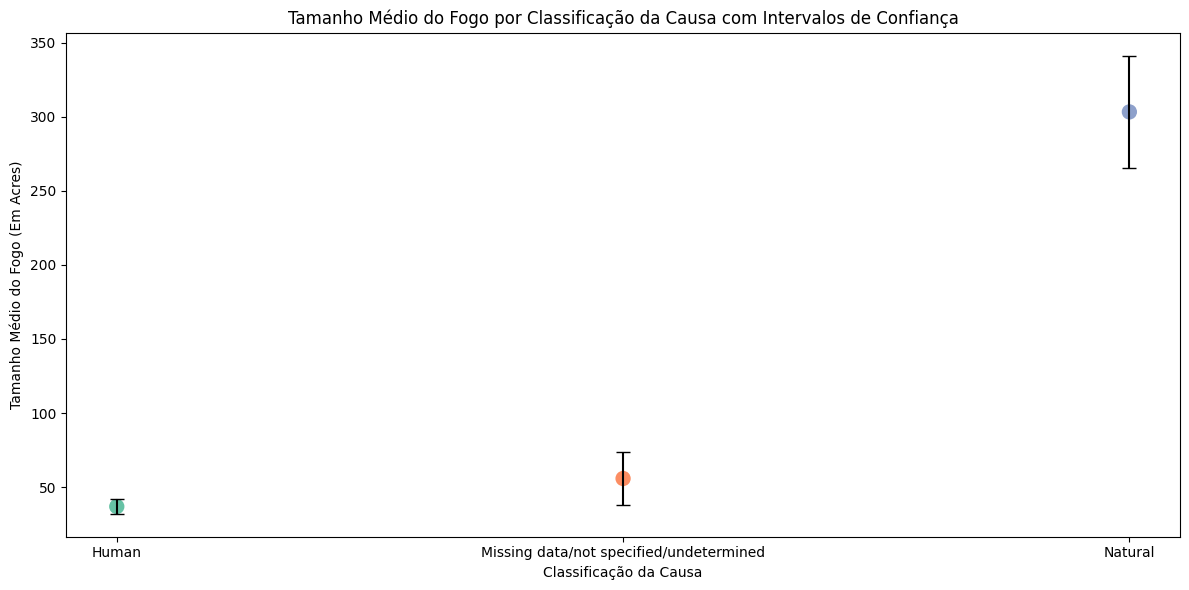

In [31]:
# Plotar o gráfico com bolinhas coloridas e intervalos de confiança
fig_ci, ax_ci = plt.subplots(figsize=(12, 6))
colors = sns.color_palette('Set2', len(mean_fire_size))

# Adicionar os pontos
ax_ci.scatter(mean_fire_size.index, mean_fire_size.values, color=colors, s=100, label="Tamanho Médio do Fogo")

# Adicionar os intervalos de confiança
ax_ci.errorbar(mean_fire_size.index, mean_fire_size.values, 
               yerr=[mean_fire_size.values - ci_lower, ci_upper - mean_fire_size.values], 
               fmt='none', c='black', capsize=5)

# Configurar os rótulos e título
ax_ci.set_xlabel("Classificação da Causa")
ax_ci.set_ylabel("Tamanho Médio do Fogo (Em Acres)")
ax_ci.set_title("Tamanho Médio do Fogo por Classificação da Causa com Intervalos de Confiança")
plt.tight_layout()
plt.show()


No entanto é visto que as queimadas por causas naturais acaba se alastrando muito mais que as geradas por humanos.

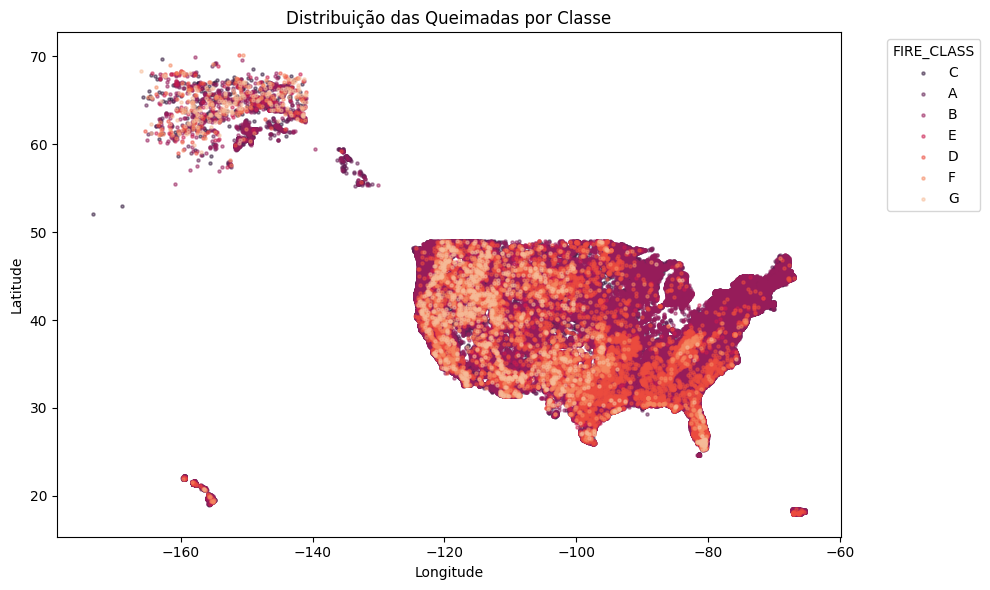

In [5]:
# Mapeando as classes de fogo para cores
fire_classes = amostra['FIRE_SIZE_CLASS'].unique()
palette = sns.color_palette("rocket", len(fire_classes))
color_map = dict(zip(fire_classes, palette))

# Plotando os pontos no plano latitude x longitude
fig, ax = plt.subplots(figsize=(10, 6))
for fire_class in fire_classes:
    subset = amostra[amostra['FIRE_SIZE_CLASS'] == fire_class]
    ax.scatter(subset['LONGITUDE'], subset['LATITUDE'], 
               label=fire_class, 
               color=color_map[fire_class], 
               alpha=0.5, s=5)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Distribuição das Queimadas por Classe')
ax.legend(title='FIRE_CLASS', bbox_to_anchor=(1.05, 1), loc='upper left')

# Exibir o gráfico
plt.tight_layout()
plt.show()

è visto que as regioes atigidas com queimadas de maior impacto foram as regioes oeste e extremo sul
'